In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import scipy
import pymaster as nmt

# File Loading and Plotting

In [3]:
lmax_beam = 6500
nsplits = 2

In [4]:
beam_filename = 'data/planck/HFI_RIMO_BEAMS_R3.01/BeamWf_HFI_R3.01/Bl_T_R3.01_fullsky_143evenx143odd.fits'
beamfits = fits.open(beam_filename)
beam = np.array(beamfits[1].data).astype(float)
mapname_head = r'data/planck/maps/PR3/frequencyMaps/HFI_SkyMap_143_2048_R3.01_full-'

In [5]:
beamfits[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2017-03-13'         /  Creation date (CCYY-MM-DD) of FITS header     
NUMEXT  =                    1 / Number of extensions                           
XTNAME1 = 'WINDOW FUNCTION'    / Name of extension #1                           
DET1    = '143even '           / Detector (set)                                 
DET2    = '143odd  '           / Detector (set)                                 
COMMENT ----------------------------------------------------------------        
COMMENT Beam Window Function B(l)                                               
COMMENT Compatible with Healpix (synfast, smoothing, ...) and PolSpice          
COMMENT To be squared before

In [6]:
fits.open(f'{mapname_head}evenring.fits')[1].header

XTENSION= 'BINTABLE'           /Written by IDL:  Mon Sep  3 21:47:10 2018       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                   40 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                   10 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2018-09-03'      

In [7]:
mapname_head = r'data/planck/maps/PR3/frequencyMaps/HFI_SkyMap_143_2048_R3.01_full-'
map0 = [hp.read_map(f'{mapname_head}evenring.fits', field=0, verbose=False)] # I
map1 = [hp.read_map(f'{mapname_head}oddring.fits', field=0, verbose=False)] # I

# map0 = [hp.read_map(f'{mapname_head}evenring.fits', field=0, verbose=False), # I
#         hp.read_map(f'{mapname_head}evenring.fits', field=1, verbose=False), # Q
#         hp.read_map(f'{mapname_head}evenring.fits', field=2, verbose=False)] # U
# map1 = [hp.read_map(f'{mapname_head}oddring.fits', field=0, verbose=False), # I
#         hp.read_map(f'{mapname_head}oddring.fits', field=1, verbose=False), # Q
#         hp.read_map(f'{mapname_head}oddring.fits', field=2, verbose=False)] # U

/home/zequnl/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


I clip the bad pixels (flagged as `-1.63750E+30`).

In [8]:
badpix0 = [(m < -1e30) for m in map0]
badpix1 = [(m < -1e30) for m in map1]

In [9]:
map0 = [ (~bp).astype(float) * m for m, bp in zip(map0, badpix0) ]
map1 = [ (~bp).astype(float) * m for m, bp in zip(map1, badpix1) ]

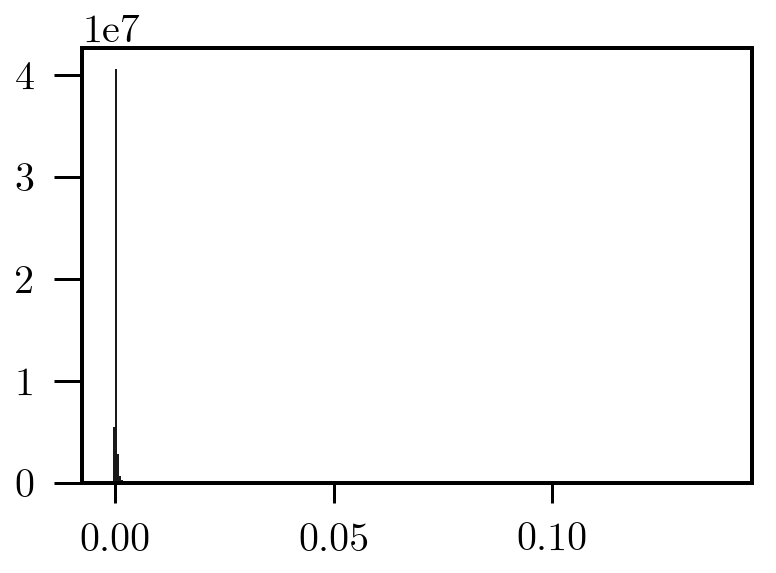

In [10]:
plt.hist(map0[0], bins=300);

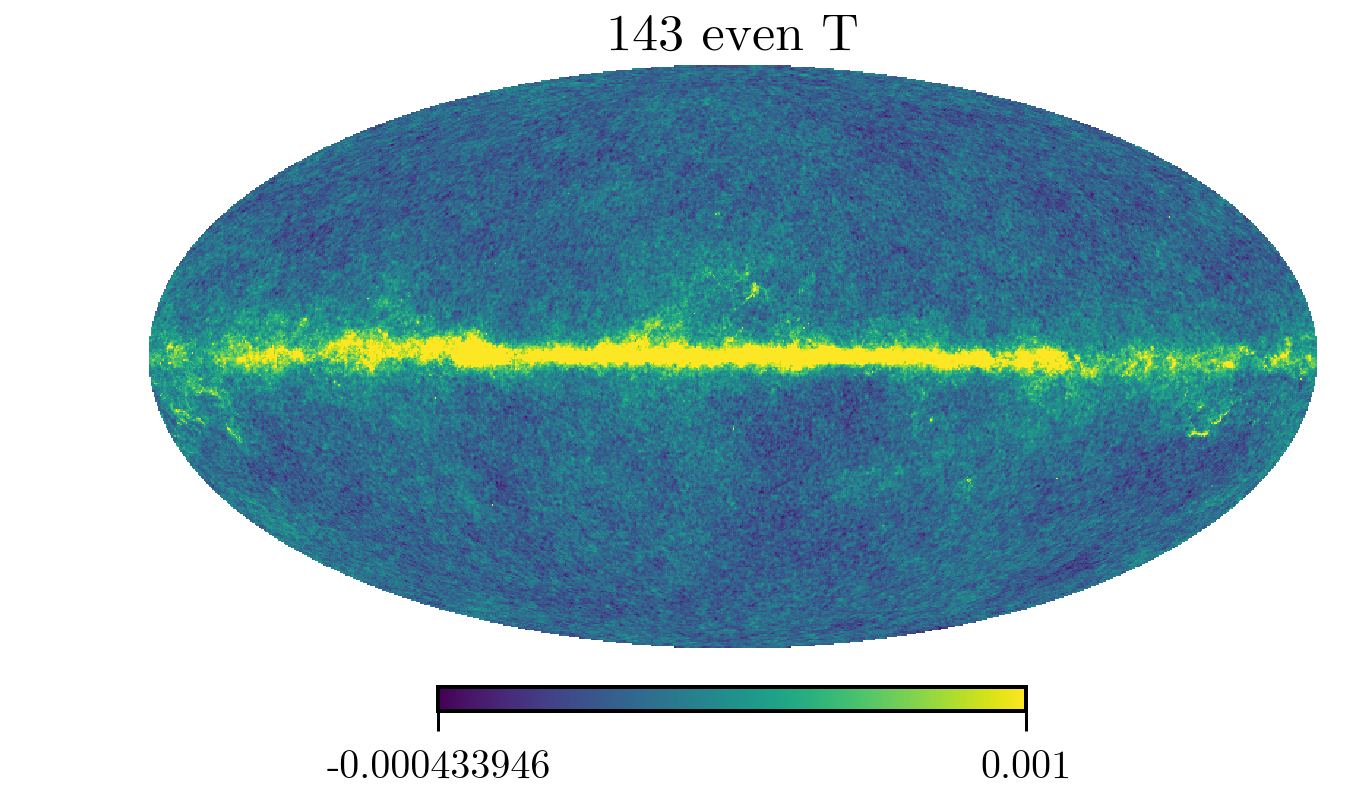

In [11]:
hp.mollview(map0[0], max=0.001, title='143 even T')

In [24]:
gal_mask_040 = hp.read_map(f'data/planck/HFI_Mask_GalPlane-apo2_2048_R2.00.fits', field=1)
point_source_mask = hp.read_map('data/planck/HFI_Mask_PointSrc_2048_R2.00.fits')

hits0 = hp.read_map(f'{mapname_head}evenring.fits', field=3, verbose=False)
hits1 = hp.read_map(f'{mapname_head}oddring.fits', field=3, verbose=False)

badpixmap0 = (~badpix0[0]).astype(float) 
badpixmap1 = (~badpix1[0]).astype(float) 
mask0 =  gal_mask_040 * point_source_mask.data * badpixmap0
mask1 =  gal_mask_040 * point_source_mask.data * badpixmap1

mask0 = nmt.mask_apodization( mask0, 2/60, apotype="C1")
mask1 = nmt.mask_apodization( mask1, 2/60, apotype="C1")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


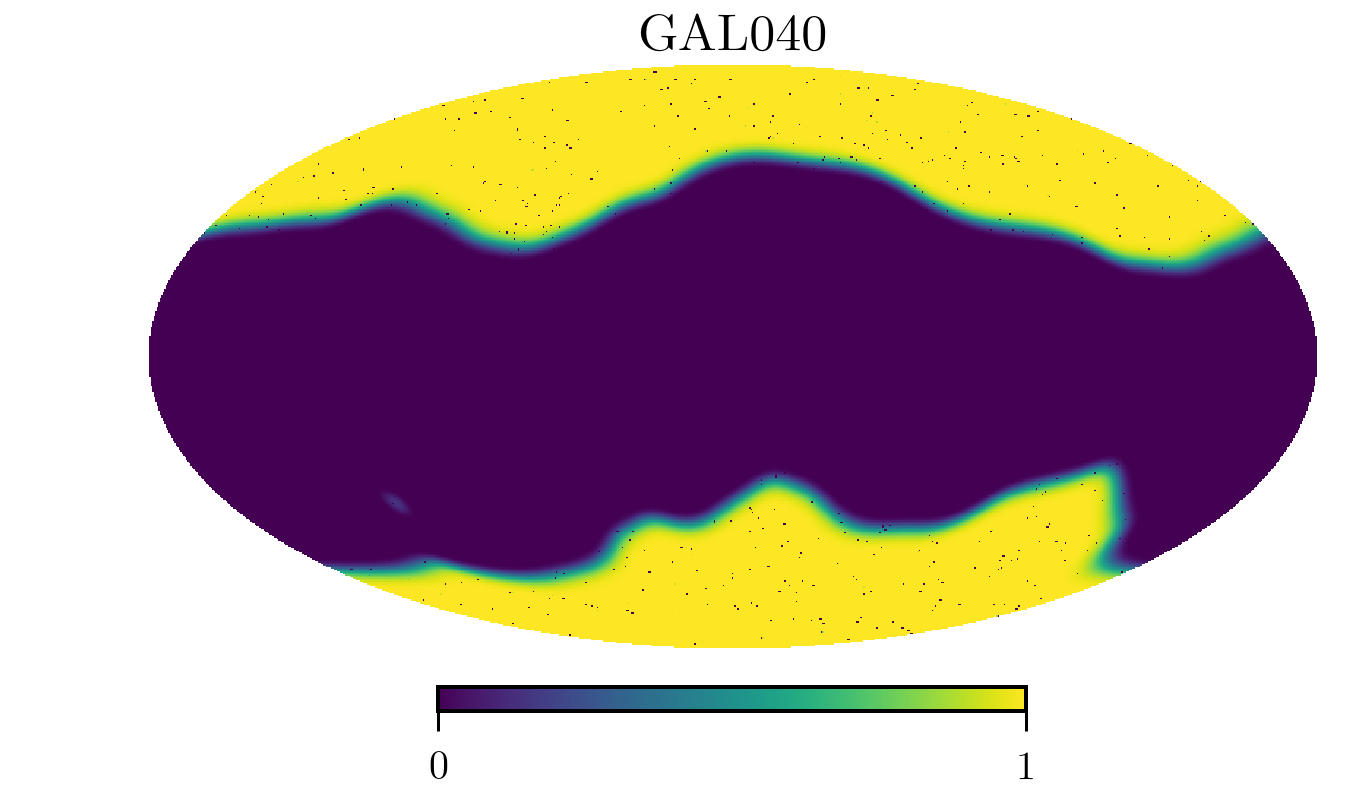

In [35]:
hp.mollview(mask0, max=1, title='GAL040')

## Beam
We plot the beam and expand the lmax.

Text(0, 0.5, '$B_{\\ell}$')

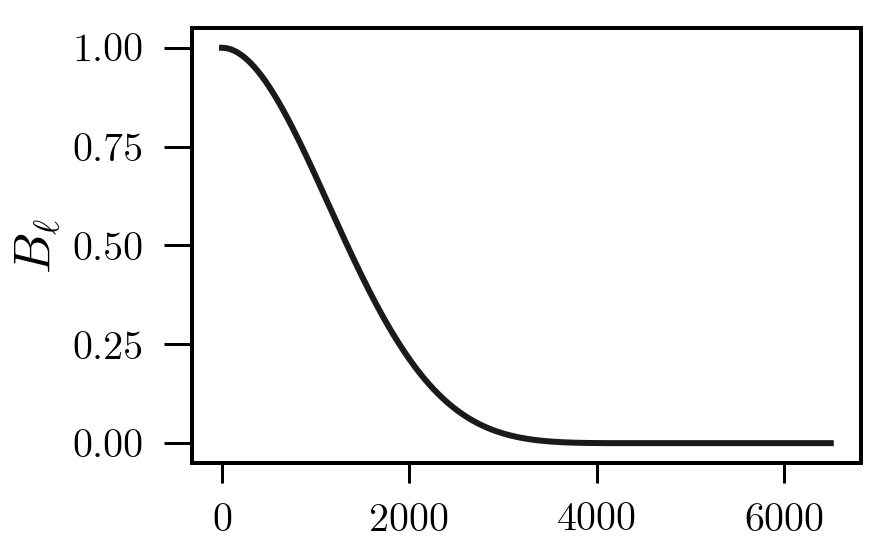

In [26]:
Bl = np.zeros(lmax_beam)
Bl[:len(beam)] = beam

plt.plot( np.arange(lmax_beam), Bl)
plt.ylabel(r"$B_{\ell}$")

# Binning

In [27]:
reference_cmb = fits.open('data/planck/COM_PowerSpect_CMB_R2.02.fits')[7]

In [28]:
binleft, binright = reference_cmb.data['LMIN'], reference_cmb.data['LMAX']
lmax = 2500
ells = np.arange(lmax)
bpws=-1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
    
weights = np.array([1.0 / np.sum(bpws == bpws[l]) for l in range(lmax)])

In [29]:
b = nmt.NmtBin(2048, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=True)
lb = b.get_effective_ells()

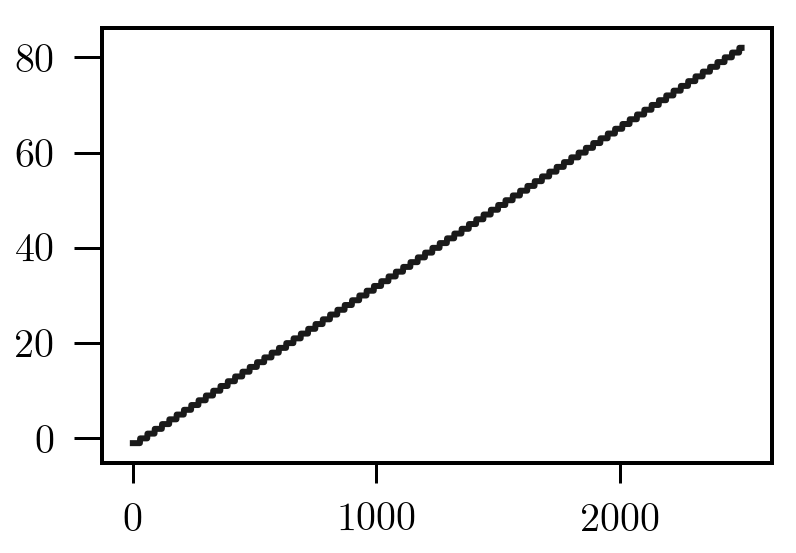

In [30]:
plt.plot(bpws)

# Power Spectra with NaMaster

## Quick Test
We compute the cross spectrum of splits 0 and 1.

In [31]:
# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask0,[map0[0]], beam=(Bl), n_iter=0)
i1 = nmt.NmtField(mask1,[map1[0]], beam=(Bl), n_iter=0)
# qu0 = nmt.NmtField(mask0,[map0[1], map0[2]], n_iter=niter)
# qu1 = nmt.NmtField(mask1,[map1[1], map1[2]], n_iter=niter)

In [32]:
cl_00 = nmt.compute_full_master(i0,i1,b)
ell = b.get_effective_ells()

(0, 6000)

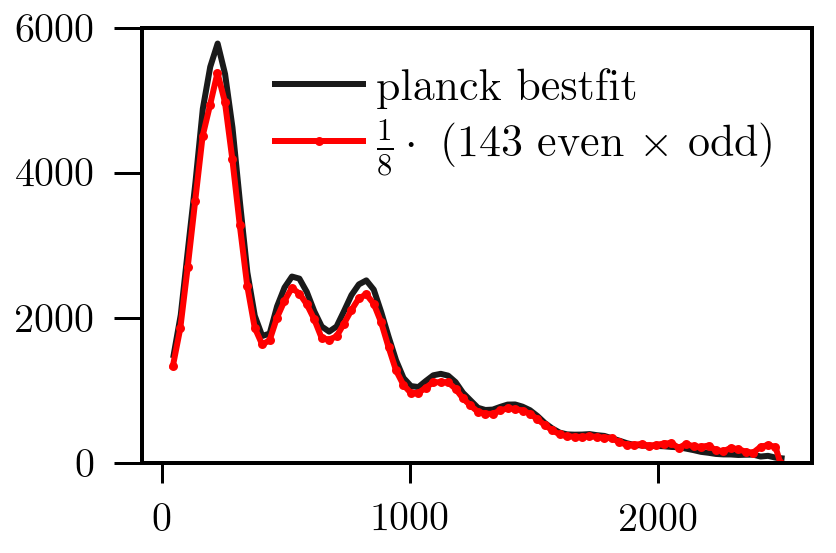

In [33]:
plt.plot(reference_cmb.data['ELL'], reference_cmb.data['D_ELL'], label='planck bestfit' )
plt.plot(ell, 1 / 8 * cl_00[0] *  2.725e6**2,'r.-',label=r"$\frac{1}{8}\cdot$ (143 even $\times$ odd)")
plt.legend()
plt.ylim(0,6000)

In [34]:
# lb = b.get_effective_ells()

# w0 = nmt.NmtWorkspace()
# w0.compute_coupling_matrix(i0, i1, b, n_iter=niter)
# w1=nmt.NmtWorkspace()
# w1.compute_coupling_matrix(i0, qu1, b, n_iter=niter)
# w2=nmt.NmtWorkspace()
# w2.compute_coupling_matrix(qu0, qu1, b, n_iter=niter)

# def compute_master(f_a,f_b,wsp) :
#     cl_coupled=nmt.compute_coupled_cell(f_a,f_b)
#     cl_decoupled=wsp.decouple_cell(cl_coupled)
#     return cl_decoupled

# Cb_namaster={}
# Cb_namaster['TT']=compute_master(i0, i1, w0)[0]
# spin1=compute_master(i0, qu1,w1)
# Cb_namaster['TE']=spin1[0]
# Cb_namaster['TB']=spin1[1]
# Cb_namaster['ET']=Cb_namaster['TE']
# Cb_namaster['BT']=Cb_namaster['TB']
# spin2=compute_master(qu0, qu1, w2)
# Cb_namaster['EE']=spin2[0]
# Cb_namaster['EB']=spin2[1]
# Cb_namaster['BE']=spin2[2]
# Cb_namaster['BB']=spin2[3]

In [23]:
# plt.plot(lb, lb**2 * Cb_namaster['TT'])